# Lectura de la Información
En este notebook nos enfocaremos en extraer la data de los archivos comprimidos y unificar las fuentes de datos. Muchas de los métodos/funciones utilizadas, serán cargadas de un archivo utils.py previamente generado para evitar sobrecarga de código en este notebook. Adicionalmente, se proponen nuevas variables a partir del uso de procesos de agrupación por cliente y/o información externa de acceso público.

### Cargar librerías necesarias

In [1]:
from utils import *
import shutil
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

### Listar archivos comprimidos y extraer archivos

In [2]:
files=[i for i in os.listdir("../data")] ## ../ hace referencia a un nivel atrás al actual, en donde se encuentran los archivos .zip
_=[shutil.unpack_archive(f'../{i}', f'../data/') for i in files if i.endswith(".zip")]

In [3]:
##extraer paths de cada archivo csv
filepaths=get_csv_filepaths([i.replace(".zip","") if i.endswith(".zip") else i for i in files])

In [4]:
##De acuerdo con validación de negocio, los archivos de siniestros son acumulativos, por tanto solo se debe utilizar el archivo de fin de año

import re


def get_12month_files(file_name:str):
    matches=re.findall("(\d{4}12\/siniestros)",file_name)
    if len(matches)==0:
        return None
    else:
        return file_name

filepaths=[j for j in [get_12month_files(i) if "siniestros" in i else i for i in filepaths] if j is not None]
filepaths=[i for i in filepaths if "old" not in i.lower()]

### Para leer las fuentes de datos se definirán grupos de archivos denotados por la variable filegroups

In [16]:
##NOTA: NO EJECUTAR SI PREVIAMENTE SE HAN GENERADO LOS ARCHIVOS .pickle por filegroup
filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']     
data={}
for filegp in filegroups:
    data[filegp]=read_by_filegroup(filegp,filepaths,save_output=True)

In [5]:
##leer archivos pickle (Checkpoint), ejecutar solo si se ejecutó la celda anterior en algún momento

filegroups=['personajuridica','personanatural','produccion','recaudo','siniestro']
data={}
for filegp in filegroups:
    data[filegp]=pd.read_pickle(f"{filegp}.pickle",compression="gzip")
    print(filegp,data[filegp].shape)

personajuridica (359467, 67)
personanatural (4679514, 69)
produccion (3789891, 63)
recaudo (6240094, 33)
siniestro (781983, 34)


### Lectura información tipo de Polizas

In [6]:
FILENAME_RAMOS="../Códigos Ramos-Productos.xlsx"
FILENAME_POLIZAS="../CODIGOS PRODUCTOS SISE.xls"
tipo_ramo,tipo_poliza,tipo_prod=pd.read_excel(FILENAME_RAMOS,sheet_name="tramo",dtype={'cod_ramo': int},skiprows=2),\
                        pd.read_excel(FILENAME_RAMOS,sheet_name="tsubramo",dtype={'cod_ramo': int,'cod_subramo':int},skiprows=2),\
                      pd.read_excel(FILENAME_POLIZAS,sheet_name="productos 3g",dtype={'ramo': int, 'codigo': str})
tipo_ramo.head()

,cod_ramo,txt_desc_redu,txt_desc
0,1,MANEJO,MANEJO
1,2,CUMPLIMIENTO,CUMPLIMIENTO
2,3,INCENDIO,INCENDIO
3,4,SUSTRACCION,SUSTRACCION
4,5,TRANSPORTES,TRANSPORTES


## Esquema de generación de la variable objetivo: churn

- Se deben explorar los campos que permiten unir las diversas fuentes de información, para ello deberá explorarse el código de asegurado o el número de la póliza
- Por definición de negocio, sólo serán tenidos en cuenta productos del segmento Personas:
    - Autos - cod_ramo: 7
    - Responsabilidad Civil- cod_ramo: 13 y Producto 4,6 y 7
    - PreviHogar (producto) - cod_ramo : 89
- Debido a que solo se tiene un año de historia, debemos tomar un periodo base y observar 12 meses después el comportamiento de los asegurados, para encontrar si renovaron o no (churn) su poliza. A través de este análisis generaremos la variable objetivo. Esto puede observarse en el siguiente gráfico. 

![img](images/caso_uso.jpg)


- Sólo serán tenidas en cuenta las pólizas de 12 meses de duración




In [7]:
date_cols=[i for i in data['produccion'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_prod=data['produccion'].drop_duplicates().copy()

In [8]:
##detectar columnas tipo fecha y convertirlas a tipo datetime

date_cols=[i for i in data['produccion'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_prod=data['produccion'].drop_duplicates().copy()
data_prod=data_prod.query("RamoComercial__c in (7,89) or (RamoComercial__c==13 and Producto__c in (4,6,7))")

def col_to_dateutc(column,trim=False):
    if trim:
        return pd.to_datetime(column,errors="coerce").dt.strftime('%m-%Y')
    else:
        return pd.to_datetime(column,errors="coerce")

for col in date_cols:
    data_prod.loc[:,col]=col_to_dateutc(data_prod[col])
    data_prod.loc[:,col+"trim"]=col_to_dateutc(data_prod[col],trim=True)


print("Total filas antes de remover duplicados: ",data['produccion'].shape[0])
print("Total filas después de remover duplicados y filtrar ramos: ",data_prod.shape[0])

Total filas antes de remover duplicados:  3789891
Total filas después de remover duplicados y filtrar ramos:  546876


In [123]:
data_prod.columns

Index(['Aliado__c', 'Aliado_coas_c', 'Facultativo', 'SucursalEmision__c',
       'SucursalRadicacion__c', 'PuntoVenta__c', 'RamoComercial__c',
       'RamoTecnico__c', 'Tipo_poliza_c', 'Producto__c', 'NumeroPoliza__c',
       'NumeroEndoso__c', 'CodigoGrupoEndoso_c', 'Asegurado__c',
       'CodigoImportanciaAsegurado__c', 'CodigoTipoAsegurado__c',
       'CodigoPlanPagos__c', 'Moneda__c', 'ValorAseg__c', 'ValorAsegCoas__c',
       'ValorPrima__c', 'ValorCoaseguroCedido_c',
       'ValorReaseguroAutomatico__c', 'ValorReaseguroFacultativo__c',
       'ValorRecaudoGastosdeEmision', 'ValorIva', 'PorcentajeComision__c',
       'ValorComision__c', 'FechaEmision__c', 'FechaFinVigencia__c',
       'FechaInicioVigencia__c', 'FechaPrimeraCuota__c', 'Asociacion__c',
       'FechaCorte__c', 'AnoFabricacionVehiculo__c', 'CapacidadYCC__c',
       'ClaseVehiculo__c', 'DigitoChequeoFormularioSOAT__c', 'EsMigrado__c',
       'MarcaVehiculo__c', 'MdeloVehiculo__c', 'NumeroFormularioSOAT__c',
       'Pla

In [9]:
##obtener descripción tipo de ramo y de subramo de producto
data_prod=data_prod.merge(tipo_ramo[['cod_ramo','txt_desc']].rename(columns={'txt_desc':'tipo_ramo_name'}),how="inner",left_on=['RamoComercial__c'],right_on=['cod_ramo']).drop(columns="cod_ramo")
print(data_prod.shape)

(546876, 69)


### Aspecto Clave

Debido a algunas diferencias de nombres en los archivos de códigos de nombres de producto (ramo y subramo), se asume la siguiente equivalencia para la unión de los datos:

- RamoComercial__c equivale a cod_ramo
- Codigo__c equivale a cod_subramo

In [10]:
##Añadir descripción tipo producto por subramo
       
data_prod.loc[:,'Producto__c']=data_prod.Producto__c.apply(lambda d: try_convert(str(d))).astype(int) ## se debe realizar un paso previo ya que el Producto__c está con valores decimales

In [11]:
data_prod=data_prod.merge(tipo_poliza.rename(columns={'txt_desc':'tipo_prod_desc'}),how="left",left_on=['RamoComercial__c','Producto__c'],right_on=['cod_ramo','cod_subramo'])
data_prod.shape

(546876, 72)

In [12]:
## existen columnas que pueden diferir en valor pero cuyo contenido puede ser unificado al usar procesos de limpieza, (ej. 4.0 vs 4, " DAÑOS" vs "DAÑOS")
## Por tanto se procede a limpiar estas columnas

data_prod.loc[:,'ClaseVehiculo__c']=data_prod.ClaseVehiculo__c.apply(lambda d: try_convert(d))
data_prod.loc[:,'TipoVehiculo__c']=data_prod.TipoVehiculo__c.apply(lambda d: try_convert(d))
data_prod.loc[:,'tipo_ramo_name']=data_prod.tipo_ramo_name.apply(lambda d: str(d).strip().lower())
data_prod.loc[:,'tipo_prod_desc']=data_prod.tipo_prod_desc.apply(lambda d: str(d).strip().lower())


### Agrupación de categorías en variables

Se hacen algunas agregaciones dado que en el archivo de subramos no se encontró mayor nivel de detalle para ramos 7 y 89

In [13]:
#data_prod.loc[:,'tipo_ramo_name']=data_prod.tipo_ramo_name.apply(lambda d: "otras" if d=="nan" else d)
UNDEFINED_RAMOS={7:'automoviles',89:'previhogar'}
data_prod['tipo_prod_desc']=data_prod.apply(lambda d: UNDEFINED_RAMOS[d['RamoComercial__c']] if d['RamoComercial__c'] in UNDEFINED_RAMOS.keys() else d['tipo_prod_desc'],axis=1)

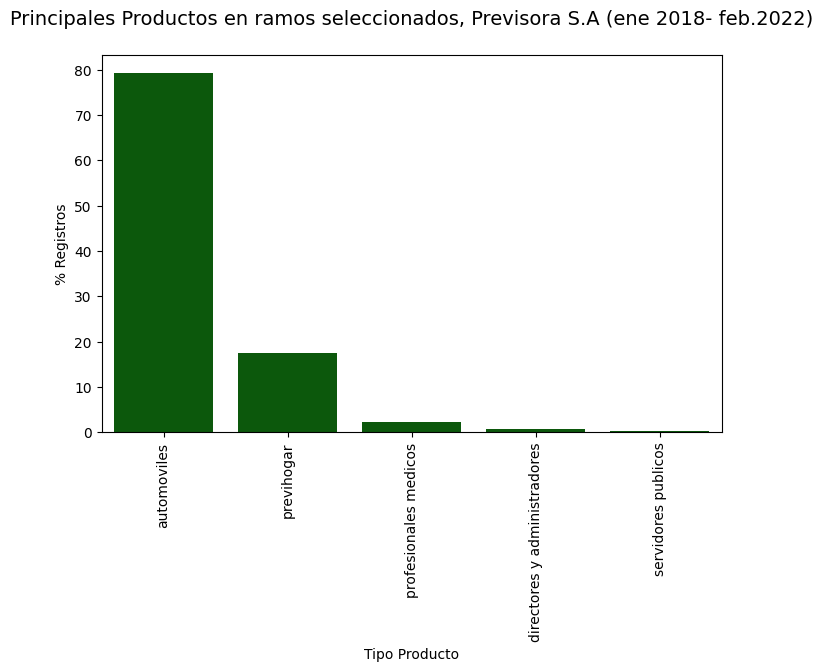

In [14]:
data_tipo_prod=data_prod.tipo_prod_desc.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=100)
sns.barplot(x=data_tipo_prod['index'],y=data_tipo_prod['tipo_prod_desc']*100,data=data_tipo_prod,ax=ax,color="darkgreen");
ax.set_title("Principales Productos en ramos seleccionados, Previsora S.A (ene 2018- feb.2022)\n",size=14)
ax.set_xlabel("Tipo Producto")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

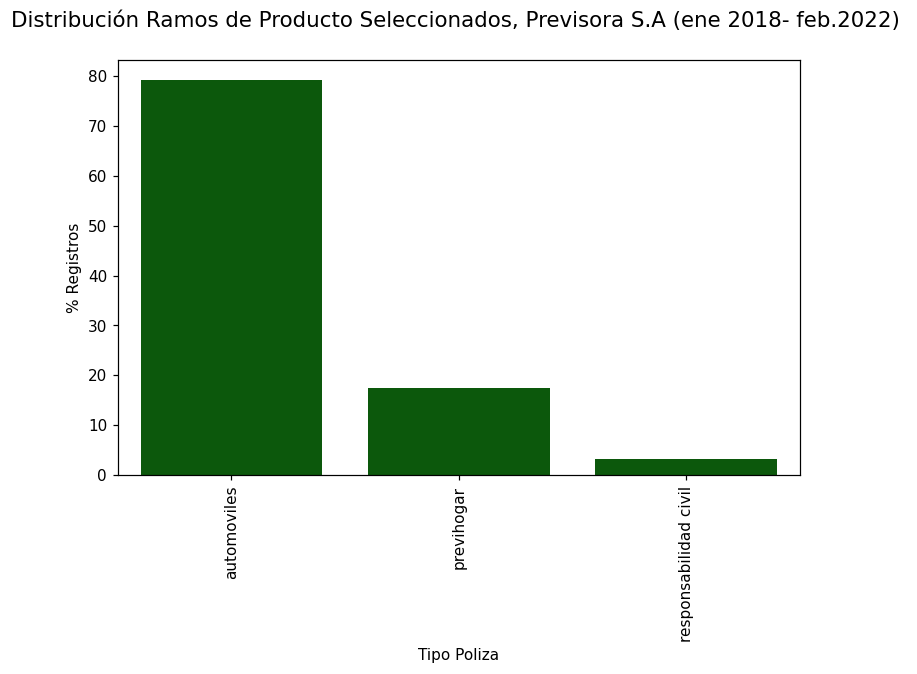

In [15]:
data_tipo_ramo=data_prod.tipo_ramo_name.value_counts(normalize=True).head(10).reset_index()

f,ax=plt.subplots(figsize=(8,5),dpi=110)
sns.barplot(x=data_tipo_ramo['index'],y=data_tipo_ramo['tipo_ramo_name']*100,data=data_tipo_ramo,ax=ax,color="darkgreen");
ax.set_title("Distribución Ramos de Producto Seleccionados, Previsora S.A (ene 2018- feb.2022) \n",size=14)
ax.set_xlabel("Tipo Poliza")
ax.set_ylabel("% Registros")
plt.xticks(rotation=90);

In [15]:
## eliminar columnas innecesarias generadas en los merge
data_prod.drop(columns=['cod_ramo','cod_subramo'],inplace=True)

In [16]:
#calcular vigencia en días de la poliza, para el MVP asumiremos solo polizas de 365 días.
data_prod.loc[:,'vigencia_dias']=data_prod.apply(lambda d: (d['FechaFinVigencia__c']-d['FechaInicioVigencia__c']).days,axis=1)
data_prod_365=data_prod.query("""vigencia_dias==365""").copy()

### Cálculo de variable objetivo: churn

Para este MVP usaremos las polizas cuya vigencia empieza en enero, febrero o marzo de cada año desde 2018 y observaremos si en el mes de su vencimiento, se observan o no nuevas polizas para el mismo código de asegurado (Asegurado__c) tipo ramo y tipo poliza (RamoTecnico__c,Tipo_poliza_c).

In [143]:
periodos={}
fechas=['01-2018','02-2018','03-2018','01-2019','02-2019','03-2019','01-2020','02-2020','03-2020','01-2021','02-2021']
for i in fechas:
    mes,anio=i.split("-")
    periodos[i]=mes+"-"+str(int(anio)+1)

In [131]:
def get_churn_data(init_data,end_data):
        """dada una data de inicio y una final, se calcula cuántos clientes renuevan o no pólizas una vez se vence la actual
           [NOTA] se asume que el churn corresponde a la no renovación en el mes de vencimiento de la póliza actual
        """
        
        churn_data=init_data[['Asegurado__c','CodigoTipoAsegurado__c','PuntoVenta__c','tipo_ramo_name','tipo_prod_desc','ClaseVehiculo__c','MarcaVehiculo__c','MdeloVehiculo__c','PlacaVehiculo__c','TipoVehiculo__c','FechaInicioVigencia__ctrim']].drop_duplicates().\
                merge(end_data[['Asegurado__c','CodigoTipoAsegurado__c','FechaInicioVigencia__ctrim','vigencia_dias','tipo_ramo_name','tipo_prod_desc']].drop_duplicates().\
                rename(columns={'vigencia_dias':'end_vig','FechaInicioVigencia__ctrim':'FechaInicio_ctrl'}),how="left",on=['Asegurado__c','CodigoTipoAsegurado__c','tipo_ramo_name','tipo_prod_desc'])
        churn_data.loc[:,'churn']=churn_data.end_vig.isnull()
        print("Total Registros: ",churn_data.shape[0])
        return churn_data

results=[]

for ini,end in periodos.items():
    print(f"{ini} - {end}")
    emisiones_inicio,emisiones_end=data_prod_365.query('FechaInicioVigencia__ctrim=="{}"'.format(ini)),data_prod_365.query('FechaInicioVigencia__ctrim=="{}"'.format(end))
    results.append(get_churn_data(emisiones_inicio,emisiones_end))

churn_data=pd.concat(results).drop_duplicates()
print("\n\t\t Total Registros para análisis Churn: ",churn_data.shape[0])


01-2018 - 01-2019
Total Registros:  3739
02-2018 - 02-2019
Total Registros:  4024
03-2018 - 03-2019
Total Registros:  3985
01-2019 - 01-2020
Total Registros:  3598
02-2019 - 02-2020
Total Registros:  3659
03-2019 - 03-2020
Total Registros:  26
01-2020 - 01-2021
Total Registros:  2
02-2020 - 02-2021
Total Registros:  7
03-2020 - 03-2021
Total Registros:  4404
01-2021 - 01-2022
Total Registros:  1810
02-2021 - 02-2022
Total Registros:  4031

		 Total Registros para análisis Churn:  29285


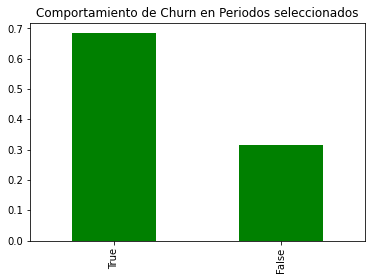

In [132]:
churn_data.churn.value_counts(normalize=True).plot(kind="bar",color="green",title="Comportamiento de Churn en Periodos seleccionados");

## Extraer Variables de Dimensiones Adicionales
### Datos de persona natural

In [19]:
#obtener nombre de ciudad usando datos del Dane
ciudades=pd.read_excel("public_data\Codigos Dane municipios.xlsx",header=1,dtype={'CÓDIGO':int})
persona_natural=data['personanatural'].merge(ciudades[['MUNICIPIO','CÓDIGO']].rename(columns={'CÓDIGO':'Ciudad__c','MUNICIPIO':'ciudad_name'}),how="left",on="Ciudad__c").copy()

In [20]:
#seleccionar variables y remover duplicadas
persona_natural=persona_natural[['CodigoAsegurado__c','Activos__c','AnnualRevenue','MontoAnual__c','OtrosIngresos__c','Profesion__pc','EgresosAnuales__c','EstadoCivil__pc','PersonBirthDate','Genero__pc','NumeroIdentificacion__c','ciudad_name']].drop_duplicates()

In [21]:
#calcular edad
from datetime import datetime
persona_natural.loc[:,'PersonBirthDate']=pd.to_datetime(persona_natural.PersonBirthDate,errors="coerce")
persona_natural.loc[:,'edad']=persona_natural.PersonBirthDate.apply(lambda d: (pd.to_datetime(datetime.now())-d).days/365.0 if not pd.isnull(d) else np.nan)

In [22]:
#ciudades con pocos registros se agrupan en una misma categoría
ciudad_name_values=persona_natural.ciudad_name.value_counts(normalize=True).to_dict()
persona_natural.loc[:,'ciudad_name']=persona_natural.ciudad_name.apply(lambda d: "otras" if ((d in ciudad_name_values.keys() and ciudad_name_values[d]<0.01) or pd.isnull(d)) else d)

En el caso de personas naturales, existe información duplicada pero no se tiene una marca de la fecha de actualización de los registros, por tanto, se dejará un único registro por persona basado en la menor cantidad de valores nulos que se tenga. También se renombra la variable `CodigoAsegurado__c` para posteriores transformaciones de unión con otras fuentes de datos. 

In [23]:
persona_natural=persona_natural.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}).drop(columns=['NumeroIdentificacion__c','PersonBirthDate']).drop_duplicates()
persona_natural.loc[:,'n_null']=persona_natural.isnull().sum(axis=1)
persona_natural.sort_values(by=["Asegurado__c","n_null"],ascending=True,inplace=True)
persona_natural=persona_natural[~persona_natural.duplicated(subset="Asegurado__c",keep='first')]
print("Total Registros: ",persona_natural.shape[0])

Total Registros:  1731334


### Datos de Recaudo


In [24]:
# Recaudo data
recaudo=data['recaudo'][['CodigoAsegurado__c','RamoComercial__c','NumeroPoliza__c','Tipo_poliza_c','Producto__c','FechaProduccion__c','CodigoPlanPagos__c','EstadoPagos']].drop_duplicates()
recaudo.loc[:,'Producto__c']=recaudo.Producto__c.apply(lambda d: try_convert(d))
print("Total Registros: ",recaudo.shape[0])

Total Registros:  3395456


### Datos de Siniestro

Para algunos calculos necesitaremos los valores en SMMLV del año de referencia, por tanto obtenemos el histórico de salarios de BANREP


In [25]:
salarios_min=pd.read_excel("public_data\salarios_minimos_brep.xlsx",skiprows=5,skipfooter=12,dtype={'Año (aaaa)':int}).\
    rename(columns={"Salario mínimo mensual (COP)":'sal_mens_min','Año (aaaa)':'anio'})
salarios_min=salarios_min[['anio','sal_mens_min']].set_index('anio').to_dict(orient="index")

In [26]:
##convertir columnas tipo fecha a timestamp

date_cols=[i for i in data['siniestro'].columns.values if "fecha" in i.lower()]

## crear una copia del dataframe para generar reproducibilidad
data_siniestro=data['siniestro'].drop_duplicates().copy()

for col in date_cols:
    data_siniestro.loc[:,col]=col_to_dateutc(data_siniestro[col])
    data_siniestro.loc[:,col+"trim"]=col_to_dateutc(data_siniestro[col],trim=True)

## Aspectos relevantes en el cálculo de variables 

Al proponer variables para distintos momentos del tiempo donde se originaron las pólizas, debe tenerse en cuenta e imaginarse que ocurriría si la solución se aplicara al día de hoy. En este instante para cada cliente se tendría el histórico de siniestros o demás variables hasta el día en el que se analiza. Por tanto es importante considerar esto en el cálculo de variables de las que se tiene registro en el tiempo. Por tanto, para cada mes de análisis del churn, se debe tener el registro de variables de comportamiento previas a la fecha o a lo sumo, el mes previo a la generación de la póliza.

### Data de Siniestros



In [144]:
from tqdm import tqdm
def get_vars_siniestro(siniestros:pd.DataFrame,period:str):
    """
    period: str |  periodo de siniestros de referencia en el cual se desea calcular las variables correspondientes al siniesto, debe estar en "año-mes" mes con cero inicial en caso de 
    ser mayor a 9 ej: "2020-01","2020-09"
    """
    period_last="-".join(period.split("-")[::-1])+"-01"
    data=siniestros.query(f"FechaOcurrenciaSiniestro__c<'{period_last}'").copy()
    data.loc[:,'ValorPagadoSiniestros__smmlv']=data.apply(lambda d: d['ValorPagadoSiniestros__c']/salarios_min[d['FechaOcurrenciaSiniestro__c'].year]['sal_mens_min'] if d['FechaOcurrenciaSiniestro__c'].year in salarios_min.keys() else salarios_min[2020],axis=1)
    #calcular años hasta el periodo de análisis (el mes en el que se generaría la póliza)
    data.loc[:,'tiempo_stro_prev']=data.FechaOcurrenciaSiniestro__c.apply(lambda d: (pd.to_datetime(period_last)-d).days/365)
    data_agg=data.groupby(['CodigoAsegurado__c']).agg({'IdentificacionSiniestro__c':lambda x: x.nunique(),\
                        'ValorPagadoSiniestros__smmlv':np.sum,'tiempo_stro_prev':np.min}).reset_index().\
                        rename(columns={'IdentificacionSiniestro__c':'total_siniestros','ValorPagadoSiniestros__smmlv':'total_pagado_smmlv','tiempo_stro_prev':'anios_ultimo_siniestro'})
    data_agg.loc[:,'FechaInicioVigencia__ctrim']=period
    return data_agg

hist_siniestros={}

for fecha in tqdm(fechas+['02-2022']):
    hist_siniestros[fecha]=get_vars_siniestro(data_siniestro,fecha)
    
##concatenar la información
vars_siniestro=[data for _,data in hist_siniestros.items()]
vars_siniestro=pd.concat(vars_siniestro,axis=0)

100%|██████████| 12/12 [05:33<00:00, 27.78s/it]


## Data Producción

En esta información reutilizaremos los pasos generados para obtener la variable objetivo.Sin embargo, gran cantidad de variables requeridas para el posterior análisis descriptivo,ya se encuentran integradas en el objeto `churn_data`.

In [145]:
#obtener generación de polizas previas al primer mes de análisis de churn 
def get_data_prod(produccion:pd.DataFrame,period:str):
    """
    period: str |  periodo de referencia en el cual se desea calcular las variables correspondientes a  producción, debe estar en "año-mes" mes con cero inicial en caso de 
    ser mayor a 9 ej: "2020-01","2020-09"
    """
    period_last="-".join(period.split("-")[::-1])+"-01"
    data=produccion.query(f"FechaInicioVigencia__c<'{period_last}'").copy()
    data_agg=data.groupby(["Asegurado__c","CodigoTipoAsegurado__c"]).agg({'Producto__c':lambda x: x.nunique()}).reset_index().rename(columns={'Producto__c':'n_prod_prev'})
    data_agg.loc[:,'FechaInicioVigencia__ctrim']=period
    return data_agg

hist_produccion={}

for fecha in tqdm(fechas+['02-2022']):
    hist_produccion[fecha]=get_data_prod(data_prod,fecha)

vars_prod=[data for _,data in hist_produccion.items()]
vars_prod=pd.concat(vars_prod,axis=0).drop_duplicates()


100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


## Integrar variables

Integración de todas las fuentes de datos procesadas previamente

In [146]:
def integrate_data(data_base: pd.DataFrame):
    """integra data_base con toda la demás información disponible en las dimensiones consideradas"""

    base_data=data_base.copy()
    #produccion
    base_data=base_data.merge(vars_prod,how="left",on=["Asegurado__c","CodigoTipoAsegurado__c","FechaInicioVigencia__ctrim"]).drop_duplicates()
    #siniestros
    base_data=base_data.merge(vars_siniestro.rename(columns={'CodigoAsegurado__c':'Asegurado__c'}),how="left",on=["Asegurado__c","FechaInicioVigencia__ctrim"]).drop_duplicates()
    #personanatural
    base_data=base_data.merge(persona_natural,how="left",on="Asegurado__c").drop_duplicates()
    return base_data

In [147]:
churn_data_out=integrate_data(churn_data)

## Exportar churn data

Dado que se hallaron los clientes y su comportamiento en el análisis de churn, exportamos la data para su posterior uso en el análisis exploratorio

In [150]:
churn_data_out.drop(columns=['FechaInicio_ctrl','end_vig','n_null']).drop_duplicates().to_csv("churn_data.csv",sep=";",index=False)

## Data para validación Posterior

Usaremos un set de datos de pólizas generadas en febrero de 2022 para un uso posterior del caso de negocio



In [151]:
emisiones_final_feb=data_prod_365.query('FechaInicioVigencia__ctrim=="02-2022"')

In [152]:
polizas_feb22=integrate_data(emisiones_final_feb[['Asegurado__c', 'CodigoTipoAsegurado__c', 'PuntoVenta__c',
       'Producto__c', 'tipo_ramo_name', 'tipo_prod_desc', 'ClaseVehiculo__c',
       'MarcaVehiculo__c', 'MdeloVehiculo__c', 'TipoVehiculo__c',
       'NumeroPoliza__c', 'FechaInicioVigencia__ctrim']])

In [155]:
polizas_feb22.drop(columns=['n_null']).drop_duplicates().to_csv("polizas_feb22.csv",sep=";",index=False)